In [1]:
import os 
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from Bio import Phylo

import phylovelo as pv

from matplotlib import font_manager
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


/home/wangkun/LineageTracingwithscRNA/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
data_directory = "/home/wangkun/datas/KPTracer-Data"
adata = sc.read_h5ad(f"{data_directory}/expression/adata_processed.nt.h5ad")
sigscores = pd.read_csv(f"../KPTracer-release/reproducibility/Figure6_S6/data/fitness_signature_scores.tsv", sep='\t', index_col = 0)

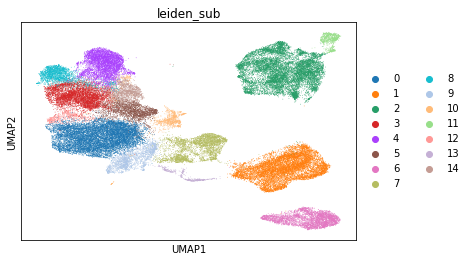

In [4]:
sc.pl.umap(adata, color='leiden_sub')

In [5]:
kii = np.intersect1d(sigscores.index, adata.obs_names)
adata.obs['FitnessSignature'] = np.nan
adata.obs.loc[kii, 'FitnessSignature'] = sigscores.loc[kii, 'FitnessSignature_NT']

In [6]:
xdr = pd.DataFrame(data=adata.obsm['X_umap'], index=adata.obs.index)
c = adata.obs['leiden_sub'].astype(int)
tree = Phylo.read('/home/wangkun/datas/KPTracer-Data/trees/3726_NT_T1_tree.nwk', format='newick')

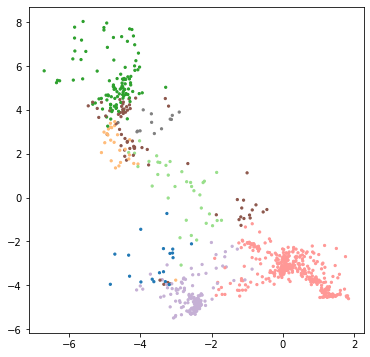

In [7]:
sel_cells = np.array([i.name for i in tree.get_terminals()])
sel_cells = sel_cells[np.isin(sel_cells, xdr.index)]
sel_xdr = xdr.loc[sel_cells]
cond = sel_xdr.iloc[:,0]<2
cond = cond & ~((sel_xdr.iloc[:,1]<3)&(sel_xdr.iloc[:,0]<-5.5))
cond = cond & ~((sel_xdr.iloc[:,1]<-5)&(sel_xdr.iloc[:,0]<1)&(sel_xdr.iloc[:,0]>-2))
sel_cells = sel_cells[cond]
sel_xdr = xdr.loc[sel_cells]
# plt.scatter(xdr.iloc[:,0], xdr.iloc[:,1], s=1)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(sel_xdr.iloc[:,0], sel_xdr.iloc[:,1], c=c[sel_cells].apply(lambda x: adata.uns['leiden_colors'][x]), s=5)

In [8]:
sel_data = adata[sel_cells]
sc.pp.filter_genes(sel_data, min_counts=10)
sd = pv.data_struct.scData(x_normed=sel_data.to_df(), phylo_tree=tree)

/home/wangkun/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.var` of view, copying.


In [9]:
depths = [len(tree.get_path(sd.phylo_tree.find_any(name=i))) for i in sd.x_normed.index]

In [10]:
sd.Xdr = xdr.loc[sd.x_normed.index]

In [11]:
sd = pv.inference.velocity_inference(sd, depths, cutoff=0.97, target='x_normed')

  0%|          | 0/11273 [00:00<?, ?it/s]

/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/wangkun/LineageTracingwithscRNA/phylovelo/inference.py:135: RuntimeWarning: invalid value encountered in double_scalars
  lr = 2 * (lh1 - lh0)


In [12]:
sd = pv.embedding.velocity_embedding(sd, target='x_normed')

  0%|          | 0/754 [00:00<?, ?it/s]

Text(-6, 6, 'AT2-like')

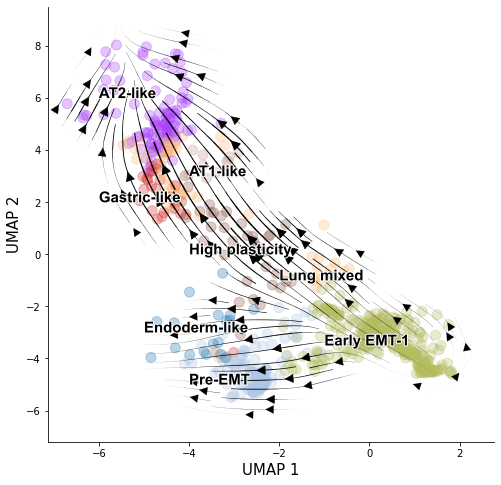

In [13]:
fig, ax = plt.subplots()
ax.scatter(sel_xdr.iloc[:,0], sel_xdr.iloc[:,1], 
           c=c[sel_cells].apply(lambda x: adata.uns['leiden_sub_colors'][x]), 
           s=100, alpha=0.3)
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream', radius=0.8, lw_coef=1500, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -5, 'Pre-EMT', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-5, -3, 'Endoderm-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 0, 'High plasticity', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -1, 'Lung mixed', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 2, 'Gastric-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
# plt.savefig('./figures/KPTracer/stream1.pdf', dpi='figure', format='pdf')

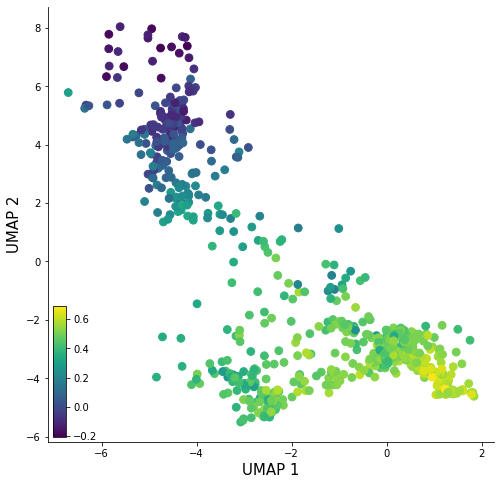

In [15]:
fig, ax = plt.subplots()
scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], 
                   c=adata.obs['FitnessSignature'][sd.Xdr.index], 
                   s=60)
# ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream', radius=0.8, lw_coef=2000, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower left') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-1.43,9)
# plt.savefig('./figures/KPTracer/fitnesssignature3726.pdf', dpi='figure', format='pdf')

In [14]:
sd = pv.pseudo_time.calc_phylo_pseudotime(sd, n_neighbors=100, r_sample=0.8)

  0%|          | 0/602 [00:00<?, ?it/s]

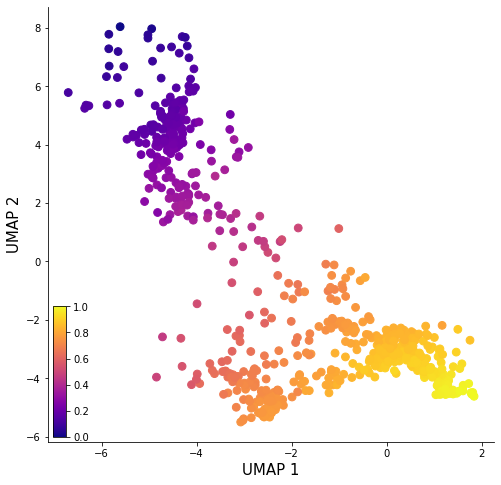

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(sd.Xdr.iloc[:,0],sd.Xdr.iloc[:,1], c=sd.phylo_pseudotime,cmap='plasma', s=60)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower left') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-2,9)
# plt.savefig('./figures/KPTracer/phylo_pseudotime1.pdf', dpi='figure', format='pdf')

In [16]:
from scipy.stats import spearmanr

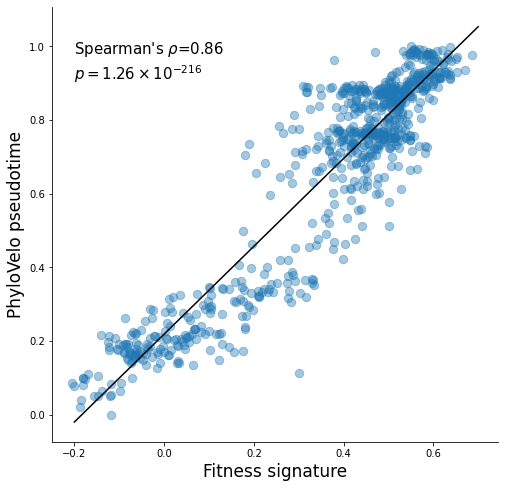

In [17]:

x = adata.obs['FitnessSignature'][sd.Xdr.index][~np.isnan(adata.obs['FitnessSignature'][sd.Xdr.index])]
y = sd.phylo_pseudotime[~np.isnan(adata.obs['FitnessSignature'][sd.Xdr.index])]

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(-0.2,0.7,60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(-0.2,0.7,60), y_est, '-', c='k')
ax.set_xlabel('Fitness signature', fontsize=17)
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
# ax.text(50, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(-0.2, 0.98, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(-0.2, 0.91, r'$p={}\times 10^{}$'.format(*r'{:.2e}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
# ax.set_ylim(-0.05,0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('./figures/KPTracer/fs_pvpt1.pdf', dpi='figure', format='pdf')

In [23]:
from sklearn.preprocessing import scale
import seaborn as sns

gene_vel_map = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns)

corrs = []
genelist = []
for i in list(gene_vel_map.index[sd.velocity!=0]):
    genelist.append(i)
    x = np.array(depths)
    y = sd.x_normed[i]
    corrs.append(spearmanr(x,y)[0])
corrs = np.array(corrs)
genelist = np.array(genelist)

genes1 = genelist[corrs>0]
genes2 = genelist[corrs<0]

genes1 = genes1[np.argsort(scale(sd.x_normed[genes1], axis=0).sum(0))]
genes2 = genes2[np.argsort(scale(sd.x_normed[genes2], axis=0).sum(0))]
genes1 = genes1[::-1]


genetraj1 = []
for i in genes1:
    genetraj1.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj1 = np.array(genetraj1)
# genetraj1 = np.log(1+genetraj1)
# genetraj1 = (genetraj1.T / np.max(genetraj1, axis=1)).T

genetraj2 = []
for i in genes2:
    genetraj2.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj2 = np.array(genetraj2)
# genetraj2 = np.log(1+genetraj2)
# genetraj2 = (genetraj2.T / np.max(genetraj2, axis=1)).T

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be 

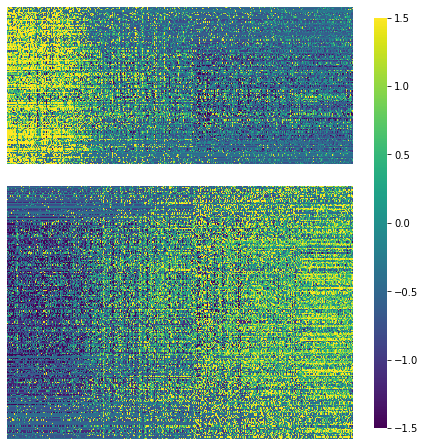

In [36]:
fig = plt.figure(figsize=(6, 6))
h1 = len(genes1)/(len(genes1)+len(genes2))
h2 = len(genes2)/(len(genes1)+len(genes2))
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.03,0.95])

ax1 = sns.heatmap(genetraj1, cmap='viridis', ax=ax1, cbar_ax=ax3,vmax=1.5, vmin=-1.5, xticklabels=False, yticklabels='')
ax2 = sns.heatmap(genetraj2[::-1], cmap='viridis', ax=ax2, cbar=False,vmax=1.5, vmin=-1.5, xticklabels=False, yticklabels='')

plt.savefig('./figures/KPTracer/heatmap_full.pdf', dpi='figure', format='pdf')

In [22]:
sd_full = pv.data_struct.scData(count=pd.DataFrame(data=adata.X.A, index=adata.obs_names, columns=adata.var_names), Xdr=pd.DataFrame(data=adata.obsm['X_umap'], index=adata.obs_names))

In [23]:
sd_full.count = sd_full.count[sd.x_normed.columns]
sd_full.x_normed = sd_full.count
sd_full.velocity = sd.velocity

In [24]:
sel_cells = adata.obs['Cluster-Name'][np.isin(adata.obs['Cluster-Name'], 
                                              ['AT1-like', 'AT2-like', 'Early gastric','Gastric-like','Late Gastric',
                                               'High plasticity','Lung progenitor-like','Endoderm-like','Early EMT-1', 'Pre-EMT'])].index

In [25]:
sd_full.count = sd_full.count.loc[sel_cells]
sd_full.x_normed = sd_full.x_normed.loc[sel_cells]
sd_full.Xdr = sd_full.Xdr.loc[sel_cells]

In [27]:
sd_full = pv.embedding.velocity_embedding(sd_full, target='x_normed', n_neigh=300)

  0%|          | 0/33773 [00:00<?, ?it/s]

Text(-8, 0.5, 'Late gastric')

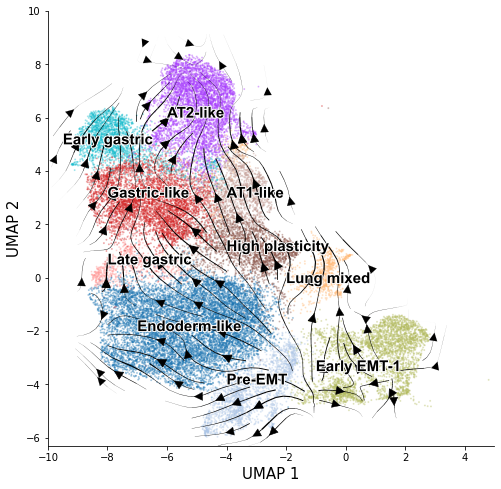

In [29]:
fig, ax = plt.subplots()
ax.scatter(sd_full.Xdr.iloc[:,0], sd_full.Xdr.iloc[:,1], 
           c=c[sd_full.Xdr.index].apply(lambda x: adata.uns['leiden_sub_colors'][x]), 
           s=1, alpha=0.3)
ax = pv.ana_utils.velocity_plot(sd_full.Xdr.to_numpy(), sd_full.velocity_embeded, ax, 'stream', radius=0.5, lw_coef=16000, streamdensity=1.5, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-6.3, 10)
ax.set_xlim(-10, 5)

ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -4, 'Pre-EMT', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-7, -2, 'Endoderm-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 1, 'High plasticity', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -0.2, 'Lung mixed', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-8, 3, 'Gastric-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-9.5, 5, 'Early gastric', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-8, 0.5, 'Late gastric', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])

# plt.savefig('./figures/KPTracer/stream_full.pdf', dpi='figure', format='pdf')

In [38]:
sd_full = pv.pseudo_time.calc_phylo_pseudotime(sd_full, n_neighbors=100, r_sample=0.02)

  0%|          | 0/674 [00:00<?, ?it/s]

(-10.0, 5.0)

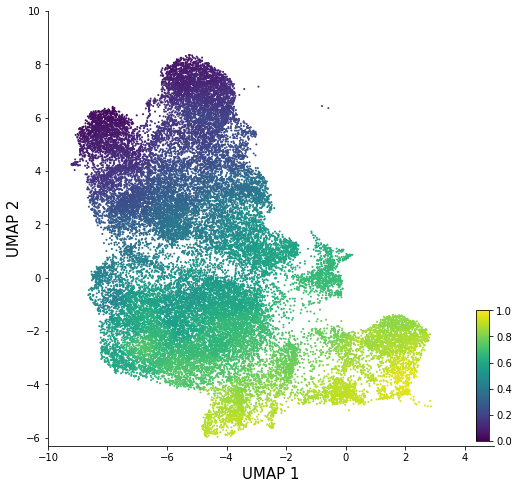

In [44]:
fig, ax = plt.subplots()
scatter=ax.scatter(sd_full.Xdr.iloc[:,0], sd_full.Xdr.iloc[:,1], 
           c=sd_full.phylo_pseudotime, 
           s=1)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-6.3, 10)
ax.set_xlim(-10, 5)

Text(5, -11, 'Mesenchymal-2 (Met)')

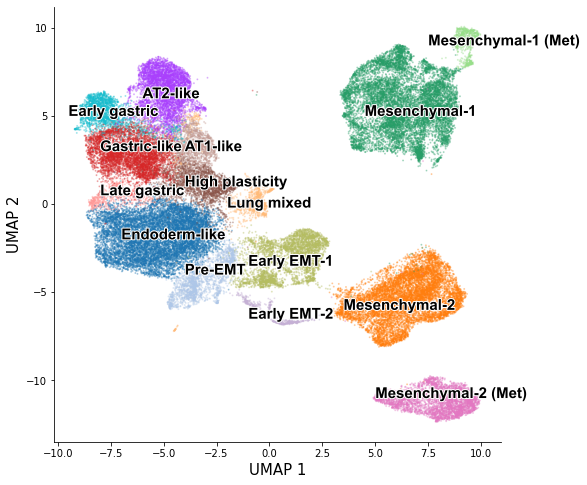

In [66]:
fig, ax = plt.subplots()
ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=[adata.uns['leiden_sub_colors'][x] for x in c[adata.obs_names]], 
           s=1, alpha=0.3)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-6.3, 10)
# ax.set_xlim(-10, 5)

ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -4, 'Pre-EMT', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-7, -2, 'Endoderm-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 1, 'High plasticity', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -0.2, 'Lung mixed', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-8, 3, 'Gastric-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-9.5, 5, 'Early gastric', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-8, 0.5, 'Late gastric', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])

ax.text(-1, -6.5, 'Early EMT-2', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(3.5, -6, 'Mesenchymal-2', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(4.5, 5, 'Mesenchymal-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(7.5, 9, 'Mesenchymal-1 (Met)', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(5, -11, 'Mesenchymal-2 (Met)', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
# plt.savefig('./figures/KPTracer/umap_full.pdf', dpi='figure', format='pdf')

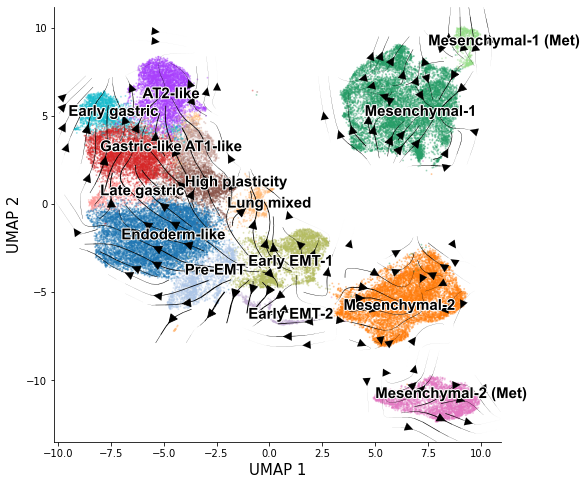

In [76]:
fig, ax = plt.subplots()
ax.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], 
           c=[adata.uns['leiden_sub_colors'][x] for x in c[adata.obs_names]], 
           s=1, alpha=0.3)
ax = velocity_plot(sd_full.Xdr.to_numpy(), sd_full.velocity_embeded, ax, 'stream', radius=0.5, lw_coef=16000, streamdensity=1.5, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-6.3, 10)
# ax.set_xlim(-10, 5)

ax.text(-1, -3.5, 'Early EMT-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, -4, 'Pre-EMT', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-7, -2, 'Endoderm-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 1, 'High plasticity', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-2, -0.2, 'Lung mixed', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-8, 3, 'Gastric-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-4, 3, 'AT1-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-6, 6, 'AT2-like', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-9.5, 5, 'Early gastric', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(-8, 0.5, 'Late gastric', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])

ax.text(-1, -6.5, 'Early EMT-2', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(3.5, -6, 'Mesenchymal-2', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(4.5, 5, 'Mesenchymal-1', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(7.5, 9, 'Mesenchymal-1 (Met)', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
ax.text(5, -11, 'Mesenchymal-2 (Met)', fontsize=15,c='black',
       fontproperties=font_manager.FontProperties(fname='/home/wangkun/arial/ARIALBD.TTF'),
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])
plt.savefig('./figures/KPTracer/velocity_full.pdf', dpi='figure', format='pdf')

In [77]:
v_megs = pd.DataFrame(data=[sd.x_normed.columns, sd.velocity]).T
v_megs.columns = ['MEGs', 'v']
v_megs['p-value'] = v_megs['MEGs'].apply(lambda x: spearmanr(sd.x_normed[x], depths)[1])
v_megs[v_megs['v']!=0].to_csv('KP3726_megs_v.csv', index=False)

In [78]:
pearsonr(depths, sd.phylo_pseudotime)

(0.4339672016242154, 5.6359639277542955e-36)

In [13]:
pd.DataFrame(sd.x_normed.columns).to_csv('kp3726_genes.csv')

In [30]:
import anndata as ad
adata_raw = ad.read_loom("/raid/wangkun/kp/KPTracer_3726.loom")
adata_raw.obs_names = [i[15:] for i in adata_raw.obs_names]
adata_raw.obs_names = [i[:-1]+'-1' for i in adata_raw.obs_names]
adata_raw.obs_names = [i.replace(':', '.') for  i in adata_raw.obs_names]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [35]:
adata_raw.obs_names = [i.replace('R_scRNA_', 'L') for  i in adata_raw.obs_names]

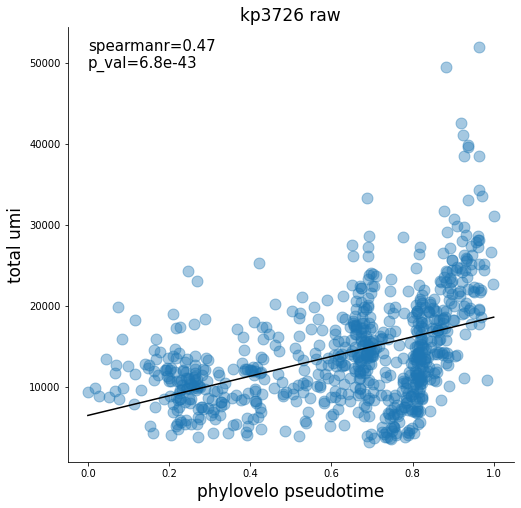

In [38]:
# plt.scatter(sd.phylo_pseudotime, sd.count.sum(axis=1))
x = sd.phylo_pseudotime
y = np.array(adata_raw[sd.x_normed.index].X.sum(axis=1)).flatten()
# y = sd.count.sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=120)
ax.plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
ax.set_ylabel('total umi', fontsize=17)
ax.set_xlabel('phylovelo pseudotime', fontsize=17)
ax.set_title('kp3726 raw', fontsize=17)
ax.text(min(x)*1.1, max(y)*0.95, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15) 
rho, pval = spearmanr(x, y)

# ax.text(min(x)*1.1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
# ax.text(min(x)*1.1, max(y)*0.85, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [47]:
adata_raw.var_names_make_unique()
adata_raw[sd.x_normed.index].to_df().T.to_csv('kp3726.csv', sep='\t')

In [45]:
sd.Xdr.to_csv('kp3726_emb.csv')

In [124]:
cts = pd.read_csv('/home/wangkun/LineageTracingwithscRNA/kp3726_cytotrace.csv', index_col=0)
cts.index = [i[:-2]+'-1' for i in cts.index]

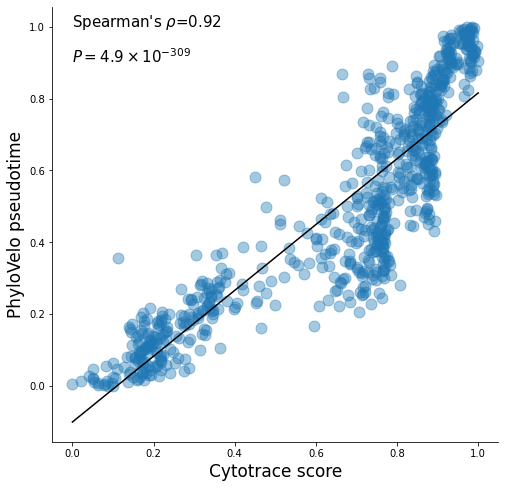

In [128]:
# plt.scatter(sd.phylo_pseudotime, sd.count.sum(axis=1))
x = sd.phylo_pseudotime
# y = np.array(adata_raw[sd.x_normed.index].X.sum(axis=1)).flatten()
y = cts.loc[sd.x_normed.index]['x']

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=120)
ax.plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
ax.set_xlabel('Cytotrace score', fontsize=17)
# ax.set_title('kp3435 normalize', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.95, r"Spearman's $\rho$={:.2g}\n$P$={:.2g}".format(*spearmanr(x, y)), fontsize=15) 
rho, pval = spearmanr(x, y)

ax.text(min(x)*1.1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
if pval:
    ax.text(min(x)*1.1, max(y)*0.9, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
else:
    ax.text(min(x)*1.1, max(y)*0.9, r'$P<10^{-100}$', fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('3726_cts_pv_cmp.pdf')

Text(0.04, 0.5, 'Total normalized UMI of MEGs')

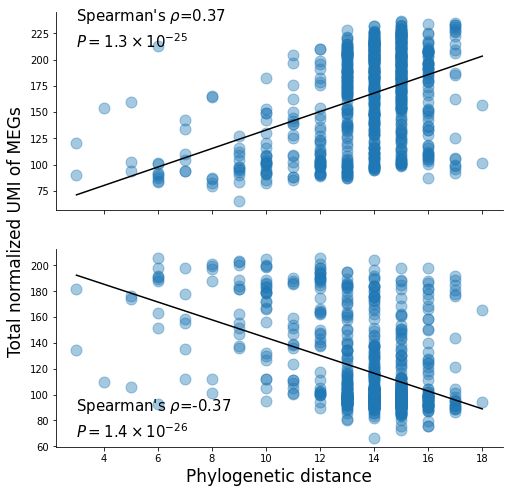

In [10]:
megs = pd.read_csv('./notebooks/KP3726_megs.csv')
from scipy.stats import spearmanr
genes1 = megs['MEGs'][megs['v']<0].to_numpy()
genes2 = megs['MEGs'][megs['v']>0].to_numpy()


x = depths
y = sd.x_normed[genes1].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax[0].scatter(x, y, alpha=0.4, s=120)
ax[0].plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
# ax[0].set_ylabel('Total normalized UMI of MEGs', fontsize=17)
# ax[0].set_xlabel('Phylogenetic distance', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.85, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)

ax[0].text(min(x)*1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax[0].text(min(x)*1, max(y)-(max(y)-min(y))*0.15, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

# ax.text(min(x)*1.1, min(y)*1.05, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
# ax.text(min(x)*1.1, min(y)*1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


x = depths
y = sd.x_normed[genes2].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b


ax[1].scatter(x, y, alpha=0.4, s=120)
ax[1].plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
# ax[1].set_ylabel('Total normalized UMI of MEGs', fontsize=17)
ax[1].set_xlabel('Phylogenetic distance', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.85, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)

ax[1].text(min(x)*1, min(y)+(max(y)-min(y))*0.15, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax[1].text(min(x)*1, min(y)*1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

fig.text(0.04, 0.5, 'Total normalized UMI of MEGs', va='center', rotation='vertical',fontsize=17)